In [1]:
import sqlite3
import pandas as pd
import random
import numpy as np
from datetime import datetime, timedelta

# Create SQLite DB
conn = sqlite3.connect("ecommerce_advanced.db")
cursor = conn.cursor()


In [2]:
# Step 3.1: Create the Customers table
cursor.execute('''
CREATE TABLE Customers (
    customer_id INTEGER PRIMARY KEY,
    name TEXT,
    country TEXT,
    join_date DATE
)
''')

# Step 3.2: Sample data setup
countries = ['USA', 'Nigeria', 'Germany', 'Brazil', 'India']
customer_data = []

for i in range(1, 1001):  # 1,000 customers
    name = f"Customer_{i}"
    country = random.choice(countries)
    join_date = datetime(2022, 1, 1) + timedelta(days=random.randint(0, 730))  # Jan 2022 to Dec 2023
    customer_data.append((i, name, country, join_date.strftime('%Y-%m-%d')))

# Step 3.3: Insert into table
cursor.executemany("INSERT INTO Customers VALUES (?, ?, ?, ?)", customer_data)
conn.commit()


In [3]:
# Step 4.1: Create the Products table
cursor.execute('''
CREATE TABLE Products (
    product_id INTEGER PRIMARY KEY,
    name TEXT,
    category TEXT,
    price REAL
)
''')

# Step 4.2: Sample product categories and items
categories = {
    'Electronics': ['Smartphone', 'Laptop', 'Tablet'],
    'Home': ['Blender', 'Vacuum Cleaner', 'Microwave'],
    'Fashion': ['T-Shirt', 'Sneakers', 'Jeans'],
    'Beauty': ['Perfume', 'Lipstick', 'Moisturizer'],
    'Sports': ['Tennis Racket', 'Basketball', 'Yoga Mat']
}

product_data = []
product_id = 1

for category, items in categories.items():
    for item in items:
        name = item
        price = round(random.uniform(15, 1500), 2)  # Prices between $15 and $1500
        product_data.append((product_id, name, category, price))
        product_id += 1

# Step 4.3: Insert into Products table
cursor.executemany("INSERT INTO Products VALUES (?, ?, ?, ?)", product_data)
conn.commit()


In [4]:
# Step 5.1: Create the Orders table
cursor.execute('''
CREATE TABLE Orders (
    order_id INTEGER PRIMARY KEY,
    customer_id INTEGER,
    product_id INTEGER,
    order_date DATE,
    quantity INTEGER,
    FOREIGN KEY(customer_id) REFERENCES Customers(customer_id),
    FOREIGN KEY(product_id) REFERENCES Products(product_id)
)
''')

# Step 5.2: Generate 15,000 random orders
order_data = []

for i in range(1, 15001):  # 15,000 orders
    customer_id = random.randint(1, 1000)
    product_id = random.randint(1, len(product_data))
    order_date = datetime(2022, 1, 1) + timedelta(days=random.randint(0, 730))  # Within 2 years
    quantity = random.randint(1, 5)
    order_data.append((i, customer_id, product_id, order_date.strftime('%Y-%m-%d'), quantity))

# Step 5.3: Insert into Orders table
cursor.executemany("INSERT INTO Orders VALUES (?, ?, ?, ?, ?)", order_data)
conn.commit()


In [5]:
# Load order and customer data into a DataFrame for RFM
query = """
SELECT
    c.customer_id,
    c.name AS customer_name,
    MAX(o.order_date) AS last_order,
    COUNT(o.order_id) AS frequency,
    ROUND(SUM(p.price * o.quantity), 2) AS monetary_value,
    ROUND((julianday('2025-06-10') - julianday(MAX(o.order_date))), 0) AS recency
FROM Orders o
JOIN Customers c ON o.customer_id = c.customer_id
JOIN Products p ON o.product_id = p.product_id
GROUP BY c.customer_id
"""

rfm_df = pd.read_sql_query(query, conn)
rfm_df.head()


,customer_id,customer_name,last_order,frequency,monetary_value,recency
0,1,Customer_1,2023-05-12,10,39546.95,760.0
1,2,Customer_2,2023-12-21,13,23627.69,537.0
2,3,Customer_3,2023-12-29,16,43251.97,529.0
3,4,Customer_4,2023-11-27,15,17377.37,561.0
4,5,Customer_5,2023-12-08,14,44120.26,550.0


In [6]:
# Assign R, F, M scores using quartiles
rfm_df['r_score'] = pd.qcut(rfm_df['recency'], 4, labels=[4, 3, 2, 1])
rfm_df['f_score'] = pd.qcut(rfm_df['frequency'].rank(method='first'), 4, labels=[1, 2, 3, 4])
rfm_df['m_score'] = pd.qcut(rfm_df['monetary_value'], 4, labels=[1, 2, 3, 4])

# Combine into RFM segment
rfm_df['rfm_segment'] = rfm_df['r_score'].astype(str) + rfm_df['f_score'].astype(str) + rfm_df['m_score'].astype(str)

# Assign segment labels
def segment_customer(row):
    if row['rfm_segment'] == '444':
        return 'Champions'
    elif row['r_score'] == '4':
        return 'Recent'
    elif row['f_score'] == '4':
        return 'Frequent'
    elif row['m_score'] == '4':
        return 'Big Spenders'
    else:
        return 'Others'

rfm_df['segment'] = rfm_df.apply(segment_customer, axis=1)
rfm_df.head()


,customer_id,customer_name,last_order,frequency,monetary_value,recency,r_score,f_score,m_score,rfm_segment,segment
0,1,Customer_1,2023-05-12,10,39546.95,760.0,1,1,3,113,Others
1,2,Customer_2,2023-12-21,13,23627.69,537.0,4,2,1,421,Others
2,3,Customer_3,2023-12-29,16,43251.97,529.0,4,3,3,433,Others
3,4,Customer_4,2023-11-27,15,17377.37,561.0,2,2,1,221,Others
4,5,Customer_5,2023-12-08,14,44120.26,550.0,3,2,3,323,Others


<ipython-input-7-2682353179>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=rfm_df, x='segment', order=rfm_df['segment'].value_counts().index, palette='coolwarm')


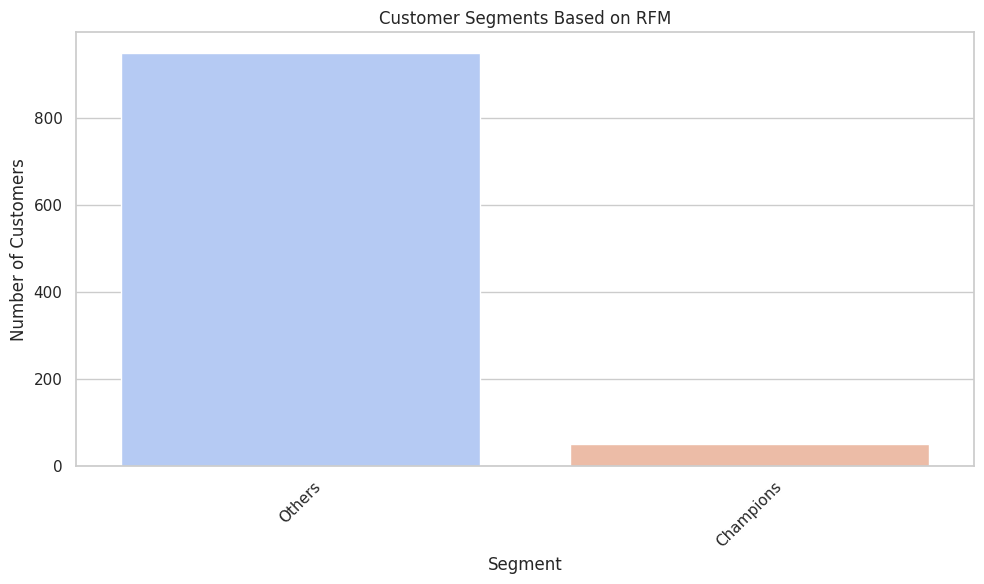

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set visual style
sns.set(style="whitegrid")

# Count of each segment
plt.figure(figsize=(10, 6))
sns.countplot(data=rfm_df, x='segment', order=rfm_df['segment'].value_counts().index, palette='coolwarm')
plt.title('Customer Segments Based on RFM')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [10]:
from operator import attrgetter


In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from operator import attrgetter  # 👈 Add this line


In [12]:
# Convert order_date to datetime
orders_df = pd.read_sql_query("SELECT * FROM Orders", conn)
orders_df['order_date'] = pd.to_datetime(orders_df['order_date'])

# Add cohort group (month of first purchase)
orders_df['order_month'] = orders_df['order_date'].dt.to_period('M')
cohort_df = orders_df.groupby('customer_id')['order_date'].min().dt.to_period('M')
orders_df['cohort_month'] = orders_df['customer_id'].map(cohort_df)

# Calculate time offset (months since cohort month)
orders_df['cohort_index'] = (orders_df['order_month'] - orders_df['cohort_month']).apply(attrgetter('n'))

# Count unique customers per cohort and index
cohort_data = orders_df.groupby(['cohort_month', 'cohort_index'])['customer_id'].nunique().reset_index()
cohort_pivot = cohort_data.pivot(index='cohort_month', columns='cohort_index', values='customer_id')
cohort_size = cohort_pivot.iloc[:, 0]
retention = cohort_pivot.divide(cohort_size, axis=0).round(3) * 100
retention.fillna(0, inplace=True)
retention


cohort_index,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
cohort_month,,,,,,,,,,,,,,,,,,,,,
2022-01,100.0,43.7,44.7,49.4,42.4,47.3,46.2,48.3,41.0,44.5,...,45.8,48.5,45.4,47.1,43.3,45.6,46.0,43.5,50.2,1.1
2022-02,100.0,51.1,44.4,44.8,47.5,51.1,55.2,47.1,52.0,41.7,...,45.7,46.6,48.9,47.5,46.2,46.2,51.1,48.9,1.3,0.0
2022-03,100.0,43.2,37.8,48.0,42.6,45.9,44.6,56.1,42.6,44.6,...,41.2,40.5,45.9,46.6,43.2,41.2,48.6,2.7,0.0,0.0
2022-04,100.0,55.9,45.6,51.5,41.2,55.9,50.0,47.1,45.6,42.6,...,54.4,52.9,52.9,42.6,52.9,44.1,0.0,0.0,0.0,0.0
2022-05,100.0,34.1,50.0,61.4,61.4,40.9,43.2,45.5,31.8,34.1,...,65.9,40.9,56.8,36.4,47.7,2.3,0.0,0.0,0.0,0.0
2022-06,100.0,50.0,31.2,50.0,56.2,31.2,50.0,56.2,50.0,56.2,...,31.2,62.5,25.0,37.5,6.2,0.0,0.0,0.0,0.0,0.0
2022-07,100.0,71.4,42.9,64.3,57.1,57.1,42.9,14.3,35.7,42.9,...,14.3,35.7,42.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-08,100.0,0.0,66.7,66.7,100.0,33.3,66.7,66.7,33.3,33.3,...,33.3,33.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-09,100.0,75.0,50.0,50.0,25.0,50.0,50.0,50.0,0.0,50.0,...,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


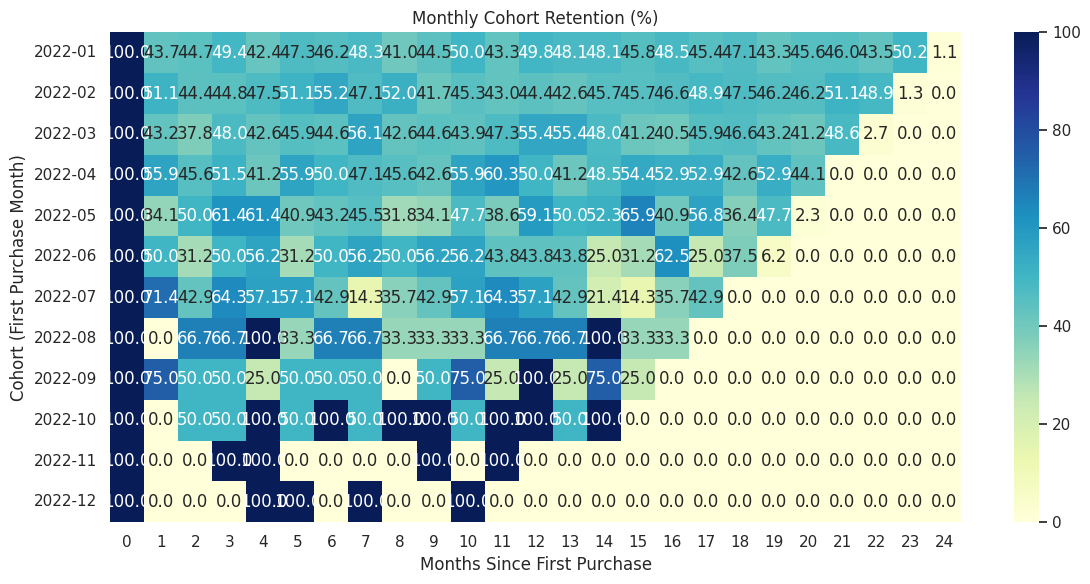

In [13]:
plt.figure(figsize=(12, 6))
sns.heatmap(retention, annot=True, fmt='.1f', cmap='YlGnBu')
plt.title('Monthly Cohort Retention (%)')
plt.xlabel('Months Since First Purchase')
plt.ylabel('Cohort (First Purchase Month)')
plt.tight_layout()
plt.show()


In [14]:
# Latest date in dataset
latest_date = pd.to_datetime('2024-06-10')  # Use your actual data's last date

# Get last purchase date per customer
last_purchase = orders_df.groupby('customer_id')['order_date'].max().reset_index()
last_purchase['days_since_last_order'] = (latest_date - last_purchase['order_date']).dt.days

# Flag churn: if no purchase in last 90 days
last_purchase['churned'] = last_purchase['days_since_last_order'] > 90

# Merge with customer info
churn_df = pd.merge(last_purchase, pd.read_sql_query("SELECT * FROM Customers", conn), on='customer_id')
churn_df.head()


,customer_id,order_date,days_since_last_order,churned,name,country,join_date
0,1,2023-05-12,395,True,Customer_1,Brazil,2022-12-08
1,2,2023-12-21,172,True,Customer_2,India,2022-05-20
2,3,2023-12-29,164,True,Customer_3,USA,2023-08-21
3,4,2023-11-27,196,True,Customer_4,India,2022-06-25
4,5,2023-12-08,185,True,Customer_5,Nigeria,2023-02-11


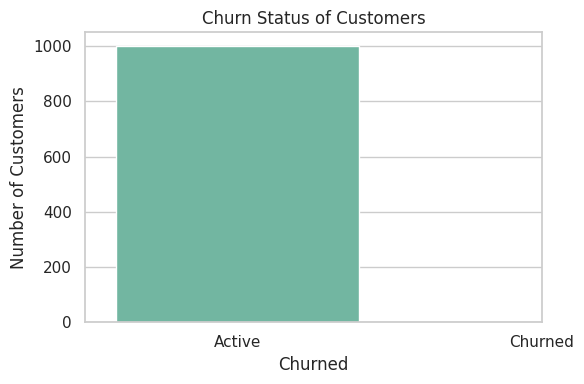

In [16]:
plt.figure(figsize=(6, 4))
sns.countplot(data=churn_df, x='churned', hue='churned', palette='Set2', legend=False)
plt.title('Churn Status of Customers')
plt.xlabel('Churned')
plt.ylabel('Number of Customers')
plt.xticks([0, 1], ['Active', 'Churned'])
plt.tight_layout()
plt.show()



In [17]:
# Make sure Customers table has 'country'
churn_df = pd.merge(last_purchase, pd.read_sql_query("SELECT * FROM Customers", conn), on='customer_id')


<ipython-input-18-2315738130>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=churn_by_country, x='country', y='churned', palette='coolwarm')


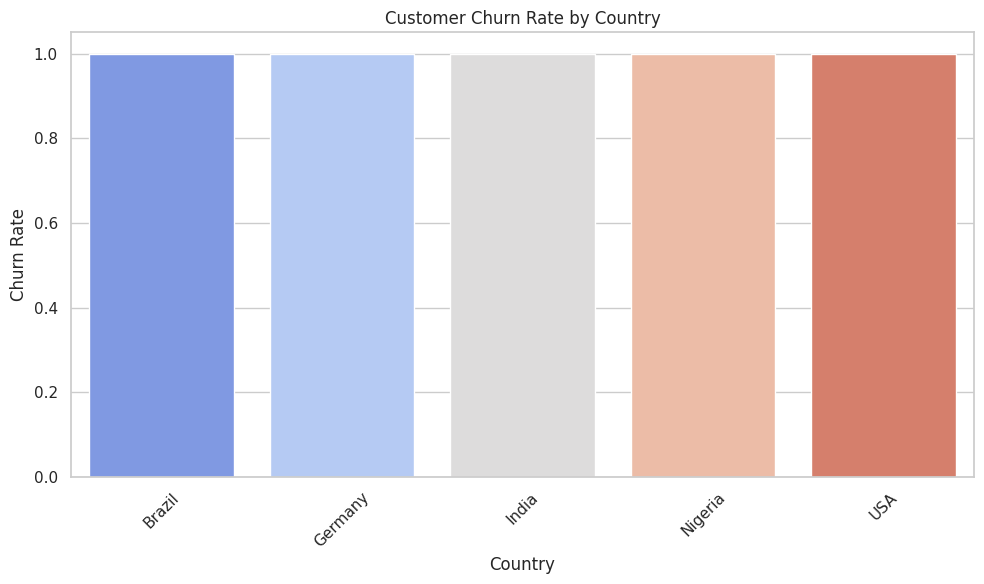

In [18]:
# Churn rate by country
churn_by_country = churn_df.groupby('country')['churned'].mean().sort_values(ascending=False).reset_index()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=churn_by_country, x='country', y='churned', palette='coolwarm')
plt.title('Customer Churn Rate by Country')
plt.ylabel('Churn Rate')
plt.xlabel('Country')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
